The goal of this notebook is to determine if ISM * dosage concords well with Enformer (baseline or finetuned)
predictions. If the concordance is high, this indicates that the model is making a linear prediction based on the
dosages. We hypothesize that after finetuning the concordance will decrease.

In [2]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from tqdm.notebook import tqdm

sys.path += ["../../", "../../../predixcan_lite"]
import evaluation_utils
import utils

In [20]:
COUNTS_PATH = "../../../process_geuvadis_data/log_tpm/corrected_log_tpm.annot.csv.gz"
FINETUNED_ISM_DIR = "/data/yosef3/scratch/ruchir/finetuning-enformer/saved_models/regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3/ism"
FINETUNED_PREDS = "/data/yosef3/scratch/ruchir/finetuning-enformer/saved_models/regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3/test_preds.npz"
SEQLEN = 384 * 128

FIGURES_DIR = "../../figures"

In [11]:
counts_df = pd.read_csv(COUNTS_PATH, index_col="our_gene_name")
finetuned_preds_df = evaluation_utils.load_finetuned_model_predictions(FINETUNED_PREDS)

# Get training genes
gene_to_class_map = evaluation_utils.get_gene_to_class_map()
training_genes = [g for g, c in gene_to_class_map.items() if c != "unseen"]
finetuned_preds_df = finetuned_preds_df.loc[training_genes]

In [12]:
linear_preds_df = finetuned_preds_df.copy()

for gene in tqdm(training_genes):
    finetuned_preds = finetuned_preds_df.loc[gene].dropna()
    test_samples = finetuned_preds.index.tolist()
    assert len(test_samples) == 77

    # Get test dosages
    genotype_mtx = utils.get_genotype_matrix(
        counts_df.loc[gene, "Chr"], counts_df.loc[gene, "Coord"], SEQLEN
    )
    genotype_mtx = genotype_mtx.loc[:, test_samples]
    dosage_mtx = utils.convert_to_dosage_matrix(genotype_mtx)
    dosage_mtx.index = dosage_mtx.index.astype(str)

    # Load ISMs
    ism_df = pd.read_csv(os.path.join(FINETUNED_ISM_DIR, f"{gene}.csv"), index_col=0)

    # Check that the variants in the dosage matrix that we do not have ISM scores for have AC = 0
    assert set(ism_df.index).issubset(set(dosage_mtx.index))
    for v in set(dosage_mtx.index) - set(ism_df.index):
        assert dosage_mtx.loc[v].sum() == 0

    # Get ISM x dosages
    dosages_df = dosage_mtx.loc[ism_df.index]
    dosages = dosages_df.to_numpy().T
    isms = ism_df["ISM"].to_numpy()
    linear_preds = dosages @ isms
    linear_preds_df.loc[gene, test_samples] = linear_preds

  0%|          | 0/400 [00:00<?, ?it/s]

In [13]:
def compute_pearson_correlations_with_ground_truth(
    df1: pd.DataFrame, df2: pd.DataFrame
) -> dict[str, float]:
    """
    For metric == r2_score, df1 should contain the true values and df2 the predictions.
    """
    common_genes = df1.index.intersection(df2.index)
    correlations = {}
    for g in tqdm(common_genes):
        df1_samples = df1.loc[g].dropna().index
        df2_samples = df2.loc[g].dropna().index
        common_samples = df1_samples.intersection(df2_samples)
        assert len(common_samples) == 77 or len(common_samples) == 421
        corr, _ = pearsonr(df1.loc[g, common_samples], df2.loc[g, common_samples])
        correlations[g] = corr if not np.isnan(corr) else 0.0
    return correlations

In [14]:
def plot_correlation_comparison(
    corrs1: dict[str, float],
    corrs2: dict[str, float],
    ax: plt.Axes,
    xlabel: str,
    ylabel: str,
    title: str,
    genes: list[str] = None,
):
    if genes is None:
        genes = list(corrs1.keys() & corrs2.keys())
    else:
        assert set(genes).issubset(corrs1.keys() & corrs2.keys())

    corrs1_l = [corrs1[g] for g in genes]
    corrs2_l = [corrs2[g] for g in genes]
    sns.scatterplot(x=corrs1_l, y=corrs2_l, ax=ax)
    ax.set_xlabel(xlabel + "\n" + rf"($\mu$ = {np.mean(corrs1_l):.3f})", fontsize=15)
    ax.set_ylabel(ylabel + "\n" + rf"($\mu$ = {np.mean(corrs2_l):.3f})", fontsize=15)
    ax.set_title(title, fontsize=18)

    # Draw y = x line
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
    ax.set_aspect("equal")
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    # Add text for number of genes where corrs1 > corrs2 and vice versa
    n_corrs1_better = sum(c1 > c2 for c1, c2 in zip(corrs1_l, corrs2_l))
    n_corrs2_better = sum(c1 <= c2 for c1, c2 in zip(corrs1_l, corrs2_l))
    ax.text(
        0.83, 0.05, f"{n_corrs1_better}/{len(genes)}", transform=ax.transAxes, c="r"
    )
    ax.text(
        0.05, 0.95, f"{n_corrs2_better}/{len(genes)}", transform=ax.transAxes, c="r"
    )

In [16]:
finetuned_corrs = compute_pearson_correlations_with_ground_truth(
    counts_df, finetuned_preds_df
)
linearized_corrs = compute_pearson_correlations_with_ground_truth(
    counts_df, linear_preds_df
)

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [17]:
gene_to_class_map = evaluation_utils.get_gene_to_class_map()
random_split_genes = [
    g for g in gene_to_class_map if gene_to_class_map[g] == "random_split"
]
population_split_genes = [
    g for g in gene_to_class_map if gene_to_class_map[g] == "yri_split"
]

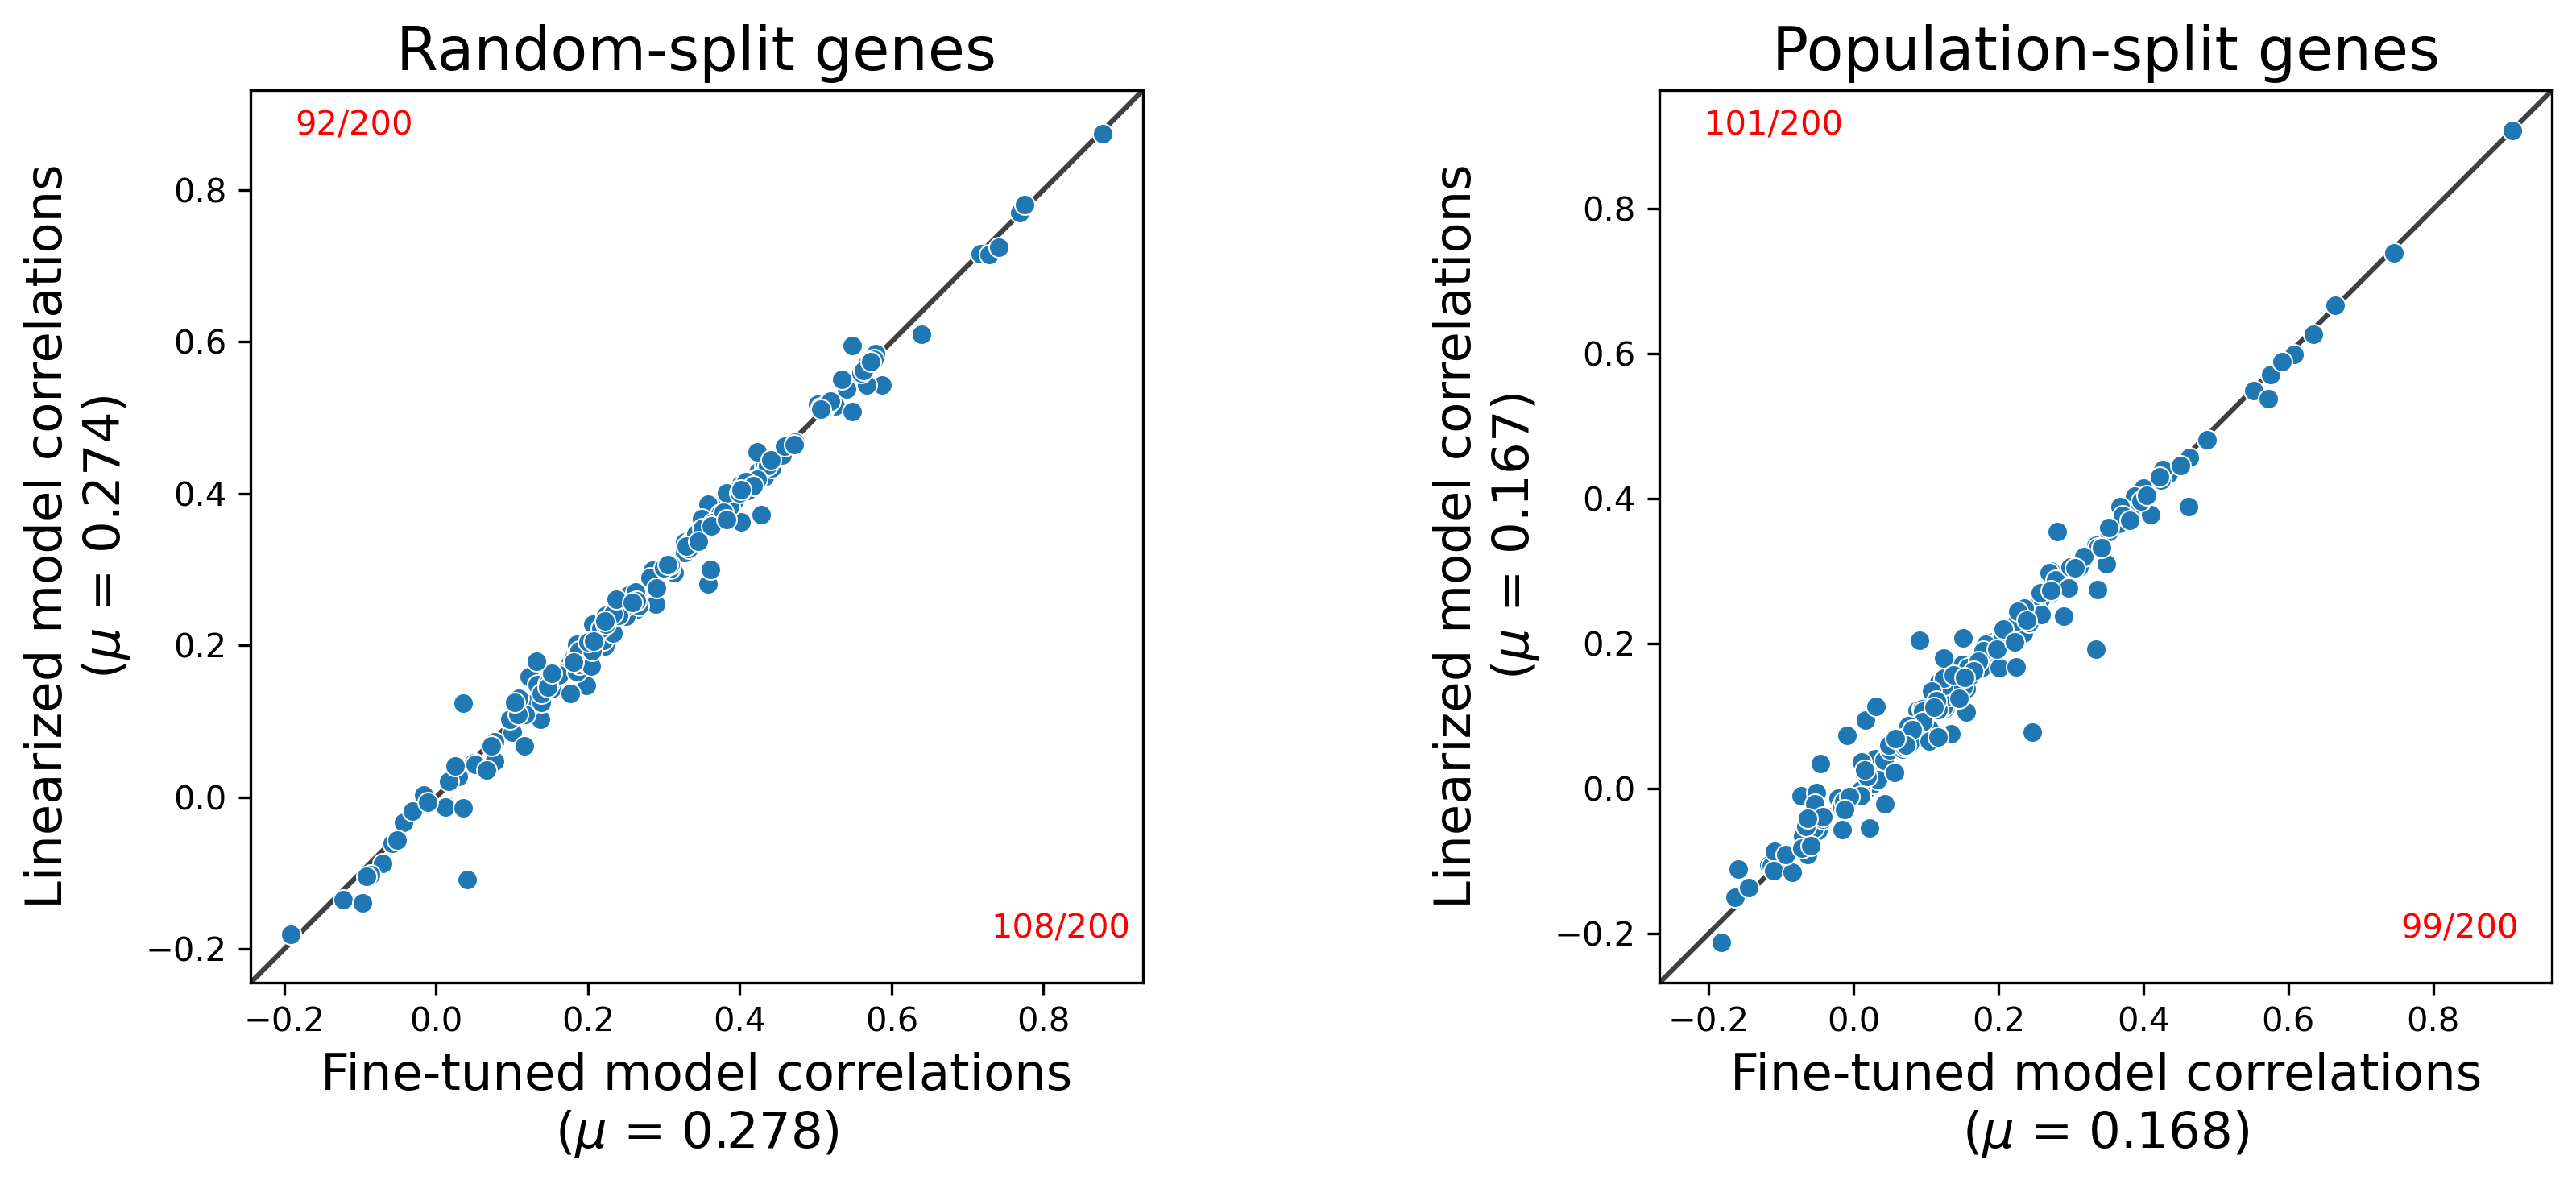

In [22]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5), dpi=300)
plot_correlation_comparison(
    finetuned_corrs,
    linearized_corrs,
    axs[0],
    "Fine-tuned model correlations",
    "Linearized model correlations",
    "Random-split genes",
    random_split_genes,
)

plot_correlation_comparison(
    finetuned_corrs,
    linearized_corrs,
    axs[1],
    "Fine-tuned model correlations",
    "Linearized model correlations",
    "Population-split genes",
    population_split_genes,
)

plt.savefig(os.path.join(FIGURES_DIR, "linearized_perf.pdf"), bbox_inches="tight")

plt.tight_layout()
plt.show()